In [1]:
import os
import sys
from pathlib import Path

base_dir=f'{Path(os.getcwd()).parent}'
sys.path.append(base_dir)


SAMPLING_RATE = 16000

import torch
torch.set_num_threads(1)

In [2]:
torch.hub.set_dir(f'{base_dir}/.model_cache/hub',)
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=False)
torch.hub.download_url_to_file('https://models.silero.ai/vad_models/en.wav', 'en_example.wav')

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/sylx/project/altbot/ai-service/.model_cache/hub/master.zip
100%|██████████| 1.83M/1.83M [00:01<00:00, 1.09MB/s]


In [28]:
import numpy as np
import librosa
window_size_samples = int(SAMPLING_RATE * 0.04) # 40 ms
vad_iterator = VADIterator(model)
wav = read_audio(f'en_example.wav', sampling_rate=SAMPLING_RATE)

f0, voiced_flag, voiced_probs = librosa.pyin(np.array(wav), fmin=50, fmax=2000, sr=SAMPLING_RATE, frame_length=window_size_samples, hop_length=window_size_samples)

In [29]:
speech_probs = []

for i in range(0,100):
    begin = i * window_size_samples
    chunk = wav[begin: begin + window_size_samples]
    if len(chunk) < window_size_samples:
      break
    speech_prob = model(chunk, SAMPLING_RATE).item()
    # chunk内のf0を計算
    chunk_np = np.array(chunk)
    speech_probs.append(speech_prob)
vad_iterator.reset_states() # reset model states after each audio


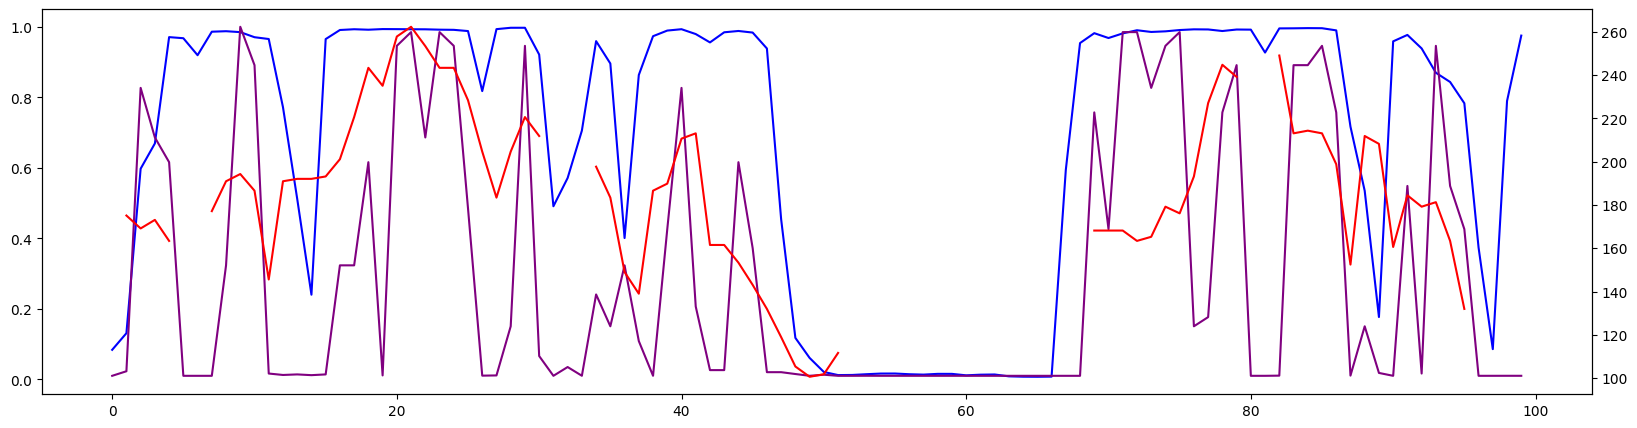

In [31]:
# plot speech probabilities
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20, 5))
ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(speech_probs,color='blue')
ax1.plot(voiced_probs[:100],color='purple')

ax2.plot(f0[:100],color='red')
plt.show()

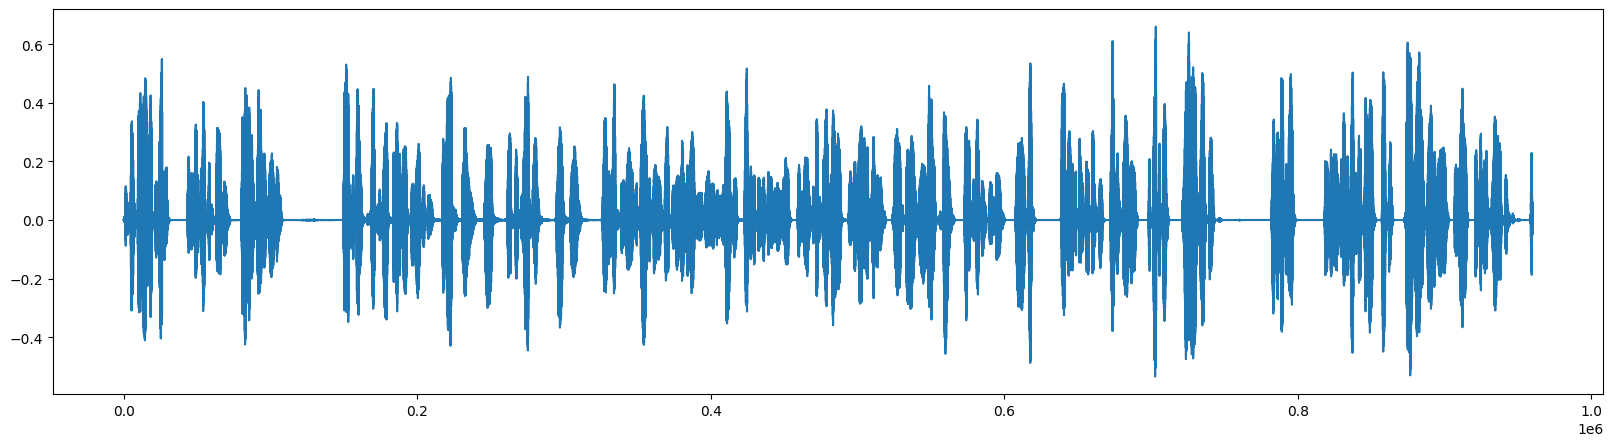

In [39]:
# speech_probsを元に音量を変化させる

output_audio = np.zeros_like(wav)
for i,prob in enumerate(speech_probs):
    begin = i * window_size_samples
    chunk = wav[begin: begin+window_size_samples]
    # concat nparray
    output_audio[begin: begin+window_size_samples] = chunk * (prob)
    

# plot wav
plt.figure(figsize=(20, 5))
plt.plot(output_audio)

In [40]:

import IPython.display as ipd
ipd.Audio(output_audio, rate=SAMPLING_RATE)
